## Решение для соревнования Kaggle по прогнозу оценки отеля на Booking



План:

1. Удаление строковых значений, очистка от пропущенных значений
2. Создание новых признаков, преобразование признаков 
3. Отбор признаков
4. Подбор и обучение модели, минимизация целевой переменной

In [2]:
%%capture
!pip install lightautoml
!pip install geopy
!pip install comet_ml
!pip install -U pandas

import pandas as pd
import numpy as np
import collections
from collections import Counter
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

from sklearn.feature_selection import chi2 # хи-квадрат

# для анализа характера отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')


# Определение констант для моделей обучения (в т.ч. lightautoml)
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600 # equal to 10 minutes
TARGET_NAME = 'reviewer_score'

# команды для максимальной воспроизводимости
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

#INPUT_DIR = '/kaggle/input/sf-booking/'
INPUT_DIR = 'data\\sf-booking\\'

# команды для максимальной воспроизводимости
np.random.seed(RANDOM_STATE)

for dirname, _, filenames in os.walk(INPUT_DIR):
# for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# изменить формат вывода pandas
pd.set_option('display.max_info_rows', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [3]:
# подгружаем данные из условий соревнования

# датасет для обучения
df_train = pd.read_csv(INPUT_DIR + '/hotels_train.csv')

# датасет для предсказания
df_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')

# тестовый сабмишн
sample_submission = pd.read_csv(INPUT_DIR + '/submission.csv')

In [4]:
# чтобы не проводить двойные преобразования df_train и df_test, объединим эти два датасета, 
# а перед запуском обучения модели их разделим, для их различия введём новый признак 'sample'

# помечаем, где у нас трейн
df_train['sample'] = 1

# помечаем, где у нас тест
df_test['sample'] = 0

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями
df_test['reviewer_score'] = 0

# объединяем данные
hotels = pd.concat([df_test, df_train], sort=False).reset_index(drop=True)

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   hotel_address                               object 
 1   additional_number_of_scoring                int64  
 2   review_date                                 object 
 3   average_score                               float64
 4   hotel_name                                  object 
 5   reviewer_nationality                        object 
 6   negative_review                             object 
 7   review_total_negative_word_counts           int64  
 8   total_number_of_reviews                     int64  
 9   positive_review                             object 
 10  review_total_positive_word_counts           int64  
 11  total_number_of_reviews_reviewer_has_given  int64  
 12  tags                                        object 
 13  days_since_review            

In [6]:
print(hotels.nunique())

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64


### Преобразование данных

In [2]:
# Залогируем проект, чтобы отслеживать изменение метрики

from comet_ml import Experiment
experiment = Experiment(
    api_key='yvb5FJsAoasdABszflop35Pbk',
    project_name='Project-3',
    workspace='lyudmilat',
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/lyudmilat/project-3/dc8acc6e858a4b228f87d4df0d40a84e



Получение первого значения\
Первая версия преобразования: удаление текстовых столбцов, заполнение средней пропущенных значений

In [8]:
hotels_initial = hotels.copy() # сделаем копию начального датасета
hotels = hotels.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review'], axis = 1)
# другой вариант
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

values = {
    'lat': hotels['lat'].mean(),
    'lng': hotels['lng'].mean()}
hotels = hotels.fillna(values)

Посмотрим, когда был оставлен самый первый/свежий отзыв?

In [9]:
# отвечаем на вопросы в юните
# Когда был оставлен самый первый/свежий отзыв?

hotels_for_questions = hotels_initial #возвращаем исходный датасет

hotels_for_questions['review_date'] = pd.to_datetime(hotels_for_questions['review_date'], format='%m/%d/%Y')
hotels_for_questions['review_date'].min()
hotels_for_questions['review_date'].max()

# Сколько уникальных тэгов, какие наиболее популярные
tag_sum = []
tags_all = []
tag_count = 0
for i in hotels_for_questions['tags']:
    tags_string = i.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip().replace("[", '').replace("]", ''), tags_list))
    for tag in tags_list:
        tags_all.append(tag)
        if tag in tag_sum :
            pass
        else: 
            tag_sum.append(tag)
            tag_count += 1

# Наиболее популярный тэг
c2 = Counter()
c = Counter(tags_all)
#print(c, tag_count)

Вторая версия с детальной проработкой данных

## Что сделаем со строковыми признаками:
1. Локация:
    1. hotel_address - в оценке отеля имеет вес так называемая удаленность от центра, и отели в столичных городах и нет - оцениваются по разному. Попробуем вытащить из этого признака город и страну
    2. У нас есть признаки долготы и широты, попробуем выгрузить точки центров столиц долготы и широты отсюда (https://www.fittotravel.net/index.php/international-data/257-coordinates-of-world-capitals) и посчитать удаленность от центра
    3. У нас есть страна человека оставившего отзыв, введем бинарный признак совпадает она со страной отеля или нет. Вероятность накрутки может быть выше, если человек местный
2. Дата отзыва: выделим день недели и признак выходной день или нет
3. Тексты отзывов: проанализируем отзывы на настроение
4. Сделаем перекрестные признаки по количеству отзывов, негативные/позитивные, с самим ревьювером
5. Из тэгов выделим несколько бинарных признаков

### 1. Локация
Начнем со всех преобразований адреса

Страна в названии последняя (за исключением Великобритании), а город предпоследний (в Великобритании 5 с конца)

In [10]:
hotels = hotels_initial #возвращаем исходный датасет

# выделяем страну
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])

# переименовываем Kingdom в United Kingdom
hotels.loc[hotels['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'
# смотрим что получилось
hotels['hotel_country'].value_counts()

# выделяем город
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
# смотрим что получилось
hotels['hotel_city'].value_counts()

hotel_city
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: count, dtype: int64

In [11]:
# Добываем данные о координатах стран и столиц
import requests # Импортируем библиотеку requests
from bs4 import BeautifulSoup
import re

url = 'https://www.fittotravel.net/index.php/international-data/257-coordinates-of-world-capitals' 
table1 = pd.read_html(url)[0]

country_locations = pd.DataFrame(table1)

# переименуем несовпадения
country_locations.loc[country_locations['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'United Kingdom'
country_locations.loc[country_locations['Country'] == 'Palau', 'Latitude'] = '7.5004N'

# видим, что в нашем датасете у Испании нет столицы, есть только Барселона. Предполагая, что нет смысла анализировать расстояние до Мадрида, заменим данные Испании на Барселону
country_locations.loc[country_locations['Country'] == 'Spain', ['Capital','Latitude', 'Longitude']] = ['Barcelona', '41.39N', '2.154E']

# Преобразуем формат геоданных
def change_type_geo(arg):
    if 'N' in arg or 'E' in arg:
        pre_result = re.findall('[0-9\.]', arg) # находит цифры и точки, преобразуем в число из строки
        result = float(''.join(pre_result))
    else:
        pre_result = re.findall('[0-9\.]', arg)
        result = - float(''.join(pre_result))
    return result

country_locations['Latitude'] = country_locations['Latitude'].apply(change_type_geo)
country_locations['Longitude'] = country_locations['Longitude'].apply(change_type_geo)
display(country_locations)

,Capital,Country,Latitude,Longitude
0,Kabul,Afghanistan,34.28,69.11
1,Tirana,Albania,41.18,19.49
2,Algiers,Algeria,36.42,3.08
3,Pago Pago,American Samoa,-14.16,-170.43
4,Andorra la Vella,Andorra,42.31,1.32
...,...,...,...,...
194,Caracas,Venezuela,10.30,-66.55
195,Hanoi,Viet Nam,21.05,105.55
196,Belgrade,Yugoslavia,44.50,20.37
197,Lusaka,Zambia,-15.28,28.16


In [12]:
# Добавим в наш основной датасет данные о центре городов
hotels = hotels.merge(
    country_locations,
    left_on='hotel_country',
    right_on='Country',
    how='left'
)
# дропнем дубляжи
hotels = hotels.drop(['Country', 'Capital'], axis = 1)
# переименуем новые столбцы
hotels.rename(columns = {'Latitude': 'latitude_center', 'Longitude' : 'longitude_center'}, inplace = True)

# больше нет смысла в названии, удаляем его
hotels = hotels.drop(['hotel_address'], axis = 1)

display(hotels.head(3))

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,latitude_center,longitude_center
0,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan,41.54,12.290
1,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,52.23,4.540
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Barcelona,41.39,2.154


In [13]:
# Добавим признак, совпадает ли страна ревьювера со страной отеля
hotels['equal_countries'] = (hotels['reviewer_nationality'] == hotels['hotel_country'])

Занимаемся геометками, делаем признак о расстоянии отеля от центра города

In [14]:
# работа с геометками
# В данных 'lat' и 'lng' есть пропуски, поэтому разделим на группы по городам и заполним медианой

# пропуски в lng и lat в одних местах, поэтому группировки по одной метрике достаточно
print(hotels[hotels['lng'].isnull()].groupby('hotel_city', as_index=False).agg(quantity=('hotel_city', 'count'))) # добавляем аргумент количества

# формируем объект SeriesGroupBy
city_hotels = hotels.groupby(['hotel_city'], group_keys=False)

# заменяем пропуски соответствующим медианным значением
hotels['lat'] = city_hotels['lat'].apply(lambda x: x.fillna(x.median()))
hotels['lng'] = city_hotels['lng'].apply(lambda x: x.fillna(x.median()))

hotels.info()

  hotel_city  quantity
0  Barcelona       207
1      Paris       382
2     Vienna      2679
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   additional_number_of_scoring                int64         
 1   review_date                                 datetime64[ns]
 2   average_score                               float64       
 3   hotel_name                                  object        
 4   reviewer_nationality                        object        
 5   negative_review                             object        
 6   review_total_negative_word_counts           int64         
 7   total_number_of_reviews                     int64         
 8   positive_review                             object        
 9   review_total_positive_word_counts           int64         
 10  total_number_of_reviews_

In [15]:
# работа с геометками
from geopy.distance import geodesic as GD

def make_distance(row):
    """
    transforming lat and lng to distance 

    Args:
        arg (_row_): row from DataFrame

    Returns:
        float: distance from the point to capital centre
    """
    result = GD((row['lat'], row['lng']), (row['latitude_center'], row['longitude_center'])).km
    return result

# делаем столбец с расстоянием до центра
hotels['Distance_to_cap_centre'] = hotels.apply(make_distance, axis=1)
display(hotels.head(3))

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,latitude_center,longitude_center,equal_countries,Distance_to_cap_centre
0,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan,41.54,12.290,False,510.170528
1,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,52.23,4.540,False,26.519505
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Barcelona,41.39,2.154,False,0.721957


### 2. Преобразования даты

In [16]:
# Преобразуем дату отзыва в формат даты
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

# Выделим признаки дня недели и выходного дня
hotels['weekday'] = hotels['review_date'].apply(lambda x: x.date().weekday())
hotels['is_weekend'] = hotels['weekday'].apply(lambda x: 1 if x in (5, 6) else 0)

# Извлечем год, месяц, день
hotels['year'] = hotels['review_date'].dt.year
hotels['month'] = hotels['review_date'].dt.month
hotels['day'] = hotels['review_date'].dt.day

# Удалим исходный столбец
hotels = hotels.drop('review_date', axis=1) 

In [17]:
# Приведем столбец days_since_review в int
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: re.search(r'\d+', x)[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int')

### 3. Тексты отзывов

In [18]:
# Анализируем характер отзыва - больше негативный или больше позитивный
sent_analyzer = SentimentIntensityAnalyzer()

# чтобы не сбивать алгоритм, заменим No Positive\No negative по принципу если нет позитивной части, то все плохо, если нет негативной, то всё хорошо
hotels.loc[hotels['negative_review'] == 'No Negative', 'negative_review'] = 'Good'
hotels.loc[hotels['positive_review'] == 'No Positive', 'positive_review'] = 'Bad'

hotels['rw_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['rw_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 
# display(hotels)

# можно выделить все метрики, а можно взять именно Compound - он агрегированный и нормализованный. также можно совместить позитивный и негативный отзыв, получить совокупный compound   
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels['sum_compound'] = (hotels['n_compound'].astype(float)+hotels['p_compound'].astype(float))/2

### 4. Перекрестные признаки с отзывами

In [19]:
# Соотношение того, сколько позитивного написали в отзыве к негативной части
hotels['positive_word_part'] = hotels['review_total_positive_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts'])
hotels['negative_word_part'] = hotels['review_total_negative_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts'])

hotels['positive_word_part'].fillna(0,inplace=True)
hotels['negative_word_part'].fillna(0,inplace=True)

display(hotels.head())

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,latitude_center,longitude_center,equal_countries,Distance_to_cap_centre,weekday,is_weekend,year,month,day,rw_neg,rw_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,sum_compound,positive_word_part,negative_word_part
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,9.171102,0,0.0,Italy,Milan,41.54,12.290,False,510.170528,4,0,2017,7,21,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,0.45305,0.54386,0.45614
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,Bad,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,52.23,4.540,False,26.519505,0,0,2016,12,12,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.216,0.784,0.000,-0.2960,1.0,0.000,0.000,-0.5423,-0.41915,0.00000,1.00000
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,41.393192,2.161520,0,0.0,Spain,Barcelona,41.39,2.154,False,0.721957,3,0,2015,11,26,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,0.34540,0.62500,0.37500
3,241,9.1,Hotel Principe Di Savoia,United States of America,Good,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,45.479888,9.196298,0,0.0,Italy,Milan,41.54,12.290,False,504.077807,5,1,2015,10,17,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...",0.000,0.000,1.000,0.4404,0.0,0.621,0.379,0.9153,0.67785,1.00000,0.00000
4,834,9.1,Hotel Esther a,United Kingdom,Good,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,52.370545,4.888644,0,0.0,Netherlands,Amsterdam,52.23,4.540,False,28.464570,0,0,2016,5,16,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...",0.000,0.000,1.000,0.4404,0.0,0.230,0.770,0.7717,0.60605,1.00000,0.00000


### 5. Тэги

In [20]:
# подсмотрела разбивку тегов и полную общность в kaggle 'Project-3 [SF-DST] Booking reviews'

# выведем число тегов для каждого отеля в отдельный признак
hotels['tags_count'] = hotels['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))

# посмотрим сколько тегов бывает по количеству, ищем максимум 
hotels['tags_count'].unique()

# смотрим структуру признака 'tag'
print(hotels[hotels['tags_count'] == hotels['tags_count'].max()]['tags'].iloc[0])
print(hotels[hotels['tags_count'] == hotels['tags_count'].max()]['tags'].iloc[3])

[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe King Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


In [21]:
# подсмотрела разбивку тегов и полную общность в kaggle 'Project-3 [SF-DST] Booking reviews'

def get_tags(tags_string):
    """ Функция кодирования отдельных тегов в новый признак

    Args:
        tags_string (str): строкое значение признака 'tags', передаваемое в обработку

    Returns:
        int: возвращает коды будущих признаков
    """

    # убираем лишнюю информацию (т.е. "мусор")
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    
    # "нарезаем" оставшуюся строку тегов во временный список
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list)) # .strip() - помогает разработчику удалить пробелы или определенные символы из строки в начале и в конце строки

    # "кодируем" путешественника(-ов)
    reviewer_types = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    # "кодируем" тип комнаты
    # словарь "выносится" наружу только ради графиков (для формирования меток по оси абсцисс)
    global room_types
    room_types = {
            'Other': 0,
            'Premier': 1, 'Royal': 2, 'President': 3, 'Presidential': 4, 'Ordinary': 5, 
            'Adjacent': 6, 'Exception': 7, 'Luxury': 8, 'Panoramic': 9, 'Classic': 10, 
            'Loft': 11, 'Montcalm': 12, 'Privilege': 13, 'Special': 14, 'Camper': 15, 
            'Sensation': 16, 'Classique': 17, 'Privilege': 18, 'Wonderful': 19, 'Deluxe': 20,
            'Premium': 21, 'Quadruple': 22, 'Triple': 23, 'Duplex': 24, 'Penthouse': 25, 
            'Townhouse': 26, 'Connecting': 27, 'Apartment': 28, 'Apartments': 29, 'Queen': 30, 
            'King': 31, 'Comfort': 32, 'Large': 33, 'Cosy': 34, 'Cozy': 35, 
            'Extra': 36, 'Plus': 37, 'Club': 38, 'Art': 39, 'View': 40,
            'Studio': 41, 'City': 42, 'Emotion': 43, 'Suite': 44, 'Executive': 45,
            'Superior': 46, 'Guest': 47, 'Family': 48, 'Business': 49,
    }

    # задаем начальные значения новых признаков
    tag_from_mobile = 0
    tag_with_pet = 0
    
    # по умолчанию не считаем поездку командировкой, значение по умолчанию 1
    tag_leisure_trip = 1

    # по умолчанию считаем поездку, что путешественник передвигается один и без детей
    tag_reviewer_type = 1
    
    # если отзыв оставлен и отсутствуют ключевые слова 'Stayed _ night(s)',
    # будем считать, что проведена минимально 1 ночь, значение по умолчанию 1
    tag_count_nights = 1
    
    # номер по умолчанию без видовых преимуществ
    tag_view_room = 0

    # если комната в тегах отсутствует, значение по умолчанию 0
    tag_room_type = 0

    # кодируем значения обнаруженных признаков при их наличии во временном списке
    for _tag in list(tags_list):
        # признак - "отправлено с мобильного устройства"
        if _tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(_tag)

        # признак - путешествие с домашними питомцами
        if _tag == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(_tag)

        # признак - поездка рабочая (командировка)
        if _tag == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(_tag)

        # признак - поездка не связана с работой (отпуск)
        if _tag == 'Leisure trip':
            # просто убираем тег из временного списка, т.к. значение по умолчанию 1
            # tag_leisure_trip = 1
            tags_list.remove(_tag)

        # признак - состав путешествующих
        if _tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[_tag]
            tags_list.remove(_tag)

        # признак - количество ночей
        if re.fullmatch(r'Stayed\s\d+\snight\w?', _tag):
            tag_count_nights = [int(n) for n in re.findall(r'-?\d+\.?\d*', _tag)][0]
            tags_list.remove(_tag)

        # признак - имеется тег "номер с видом на..."
        if len(tags_list) > 0:
            if ('View' in tags_list[0]) | ('Panoramic' in tags_list[0]):
                tag_view_room = 1

            # кодируем тип номера
            for r_t in room_types.keys():
                if r_t in tags_list[0]:
                    tag_room_type = room_types[r_t]

            # исключения, т.к. тег идет как 'Double or Twin Room 1 2 Adults'
            if ('Double' in tags_list[0]) | ('Twin' in tags_list[0]):
                tag_room_type = 50

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_view_room, tag_room_type

# создаем новые признаки
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_view_room', 'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index).astype('int8')

In [22]:
# проверяем, какие столбцы остались, что еще надо преобразовывать
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   additional_number_of_scoring                int64  
 1   average_score                               float64
 2   hotel_name                                  object 
 3   reviewer_nationality                        object 
 4   negative_review                             object 
 5   review_total_negative_word_counts           int64  
 6   total_number_of_reviews                     int64  
 7   positive_review                             object 
 8   review_total_positive_word_counts           int64  
 9   total_number_of_reviews_reviewer_has_given  int64  
 10  tags                                        object 
 11  days_since_review                           int32  
 12  lat                                         float64
 13  lng                          

### Кодируем оставшиеся признаки, удаляем лишнее

In [23]:
hotels = pd.get_dummies(hotels, columns=['hotel_country', 'hotel_city'])

hotels = hotels.drop(['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 'latitude_center',
    'longitude_center', 'rw_neg', 'rw_pos'], axis = 1)

In [24]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   additional_number_of_scoring                int64  
 1   average_score                               float64
 2   review_total_negative_word_counts           int64  
 3   total_number_of_reviews                     int64  
 4   review_total_positive_word_counts           int64  
 5   total_number_of_reviews_reviewer_has_given  int64  
 6   days_since_review                           int32  
 7   sample                                      int64  
 8   reviewer_score                              float64
 9   equal_countries                             bool   
 10  Distance_to_cap_centre                      float64
 11  weekday                                     int64  
 12  is_weekend                                  int64  
 13  year                         

Отбор признаков.

Можно еще разделить - использовать для числовых корреляцию Пиросна, а для категориальных - Спирмена

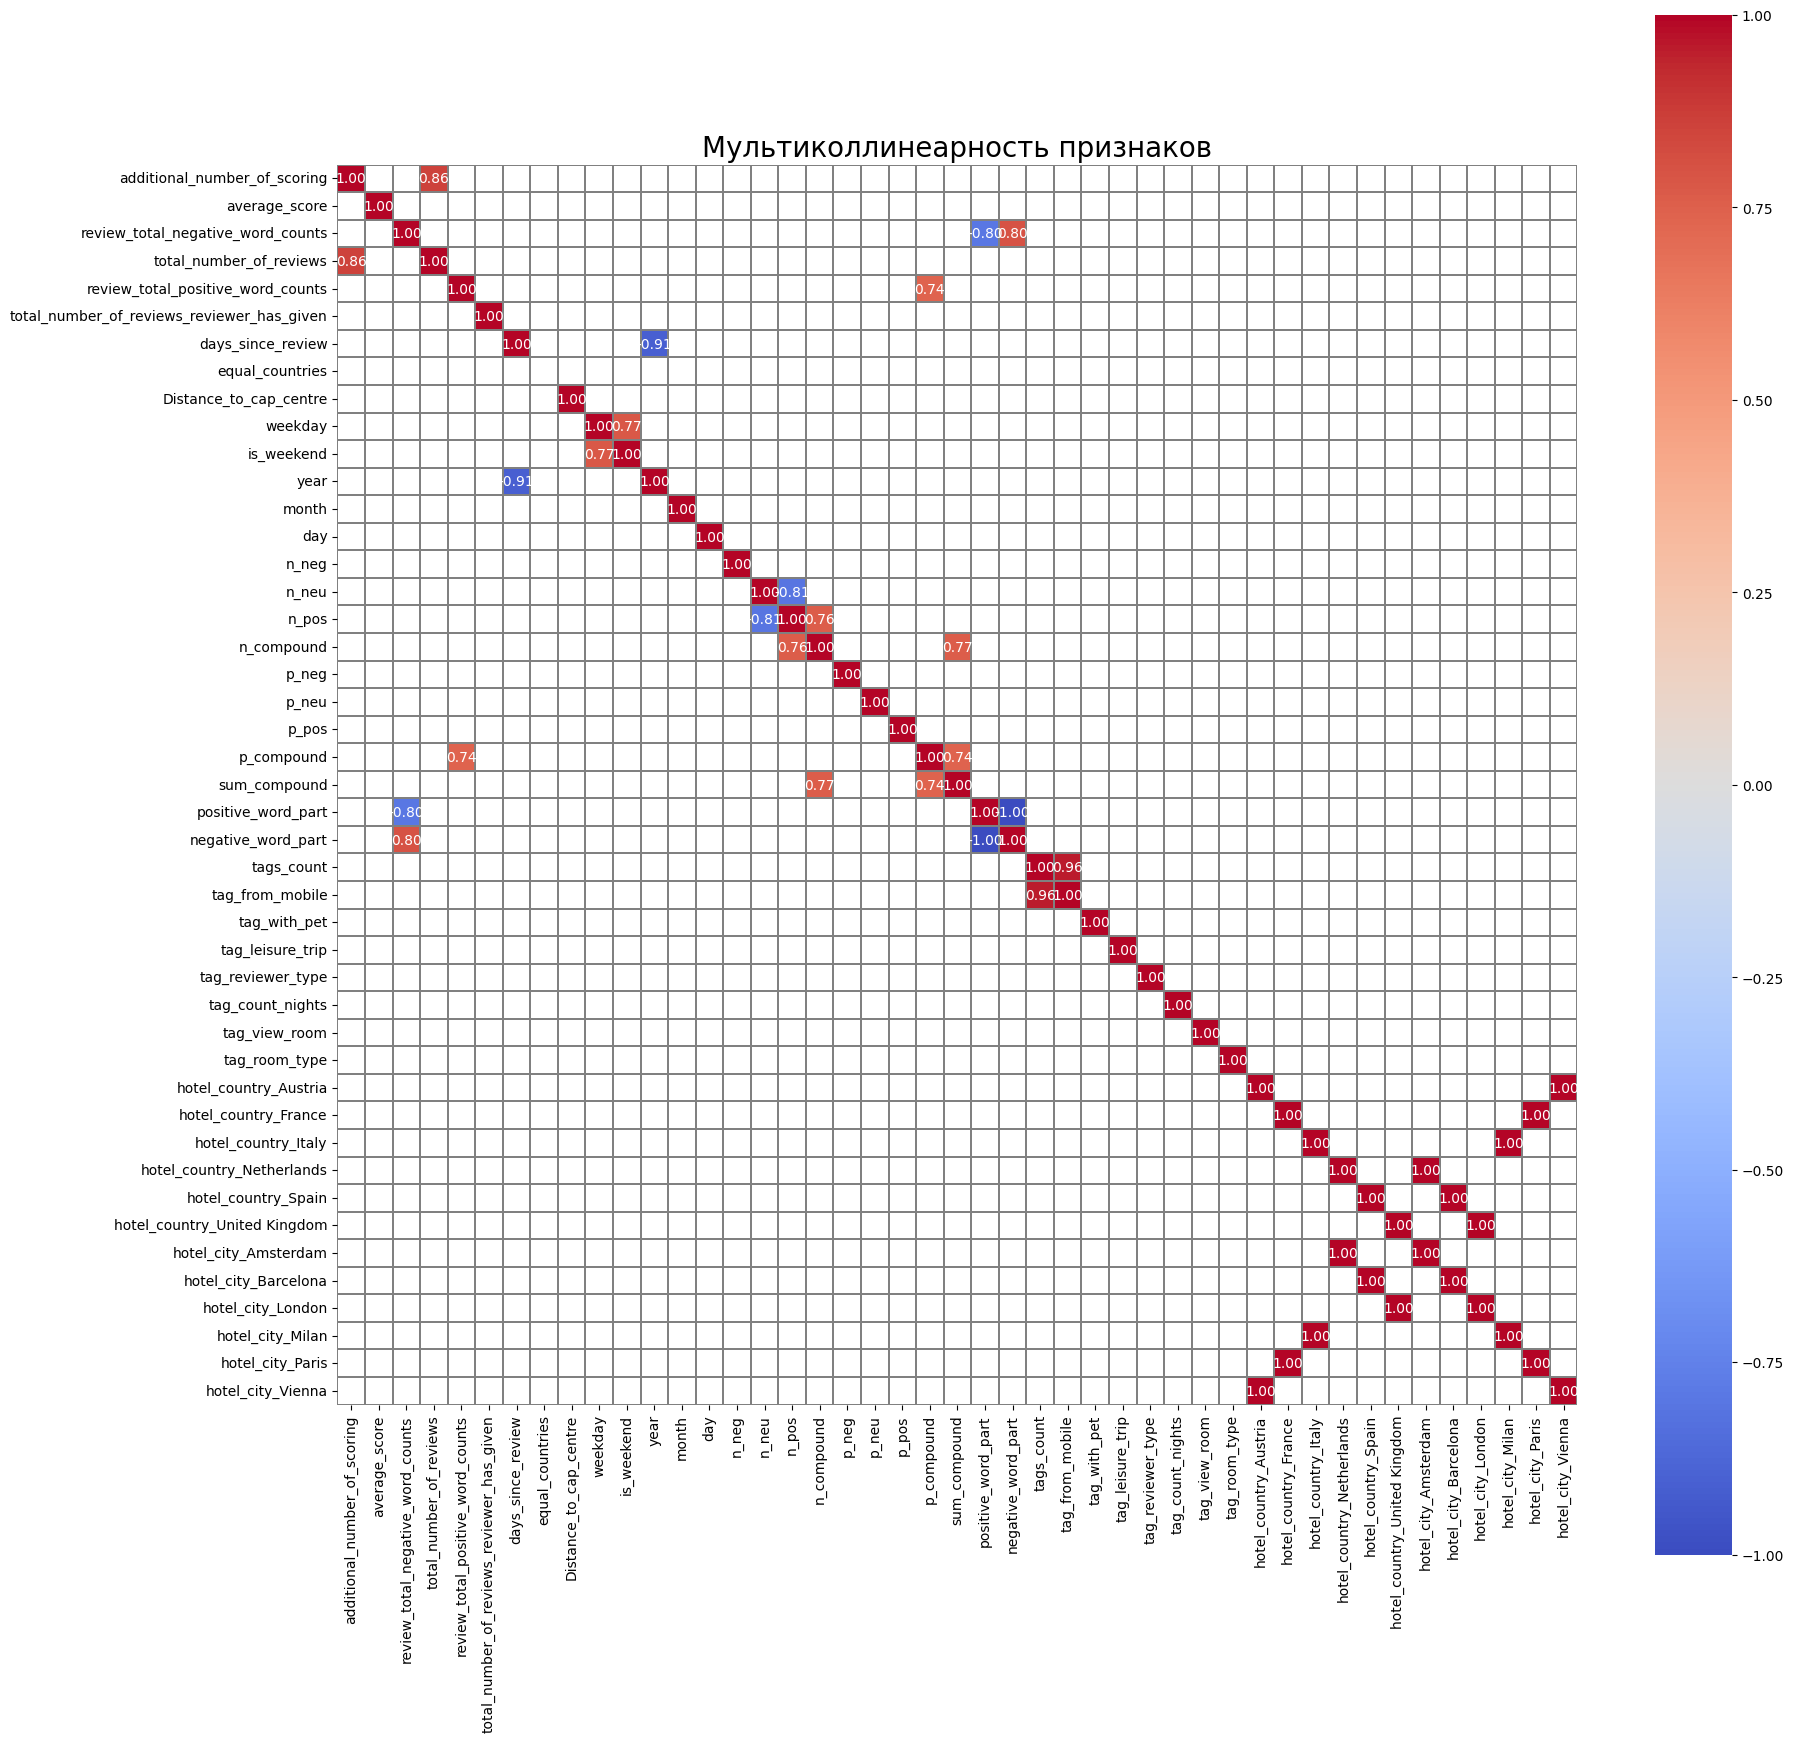

In [ ]:
# Анализ мультиколлинеарности

# данные для построения графика
corr = hotels.drop(['sample','reviewer_score'], axis=1).corr(method='spearman')
plt.subplots(figsize=(20, 20))

# график - тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

Рассмотрим в разрезе оценки ANOVA и Хи-квадрат\
Оценка значимости признаков

Для оценки значимости признаков будем использовать тесты:

- хи-квадрат - для категориальных,\
- тест ANOVA - для числовых (непрерывных) признаков.

### Разделение данных на 2 выборки

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
sample_mask = hotels['sample'] == 1
x = hotels[sample_mask].drop(['reviewer_score'], axis = 1)
y = hotels[sample_mask]['reviewer_score'].astype('int')

### Оценка значимости каждого признака для целевой переменной

In [ ]:
# При помощи теста мы сможем узнать, как географическая долгота отеля и количество негативных отзывов влияют на его рейтинг
# Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

num_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews', 'tags_count',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given', 'days_since_review', 'Distance_to_cap_centre',
             'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound', 'positive_word_part', 'negative_word_part','sum_compound']

# категориальные признаки
cat_cols = ['is_weekend', 'year', 'month', 'day', 'tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 'tag_reviewer_type', 'tag_count_nights', 
            'tag_view_room', 'tag_room_type', 'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain',
            'hotel_country_United Kingdom', 'hotel_city_Amsterdam', 'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan', 'hotel_city_Paris', 
            'hotel_city_Vienna', 'weekday','equal_countries']

y=y.astype('int')


imp_cat = pd.Series(chi2(x[cat_cols], y)[0], index=cat_cols) #  Метод chi2 возвращает массив значений хи-квадрат и p-value для каждого признака
imp_cat.sort_values(inplace = True)
#imp_cat.plot(kind = 'barh')

# сделать график, залогировать график

#experiment.log_figure(figure=plt)

По графику важности категориальных признаков мы можем понять, что признак average_score важнее, чем lat, в определении рейтинга отеля

In [ ]:
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn
from sklearn.feature_selection import f_classif # anova

# Метод f_classif возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. 
# Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.
imp_num = pd.Series(f_classif(x[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
#imp_num.plot(kind = 'barh')

По  графику важности категориальных переменных мы можем понять, что признак review_total_negative_word_counts важнее, чем total_number_of_reviews, в определении рейтинга отеля

In [ ]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [ ]:
train_data = hotels[hotels['sample'] == 1].drop(['sample'], axis=1)
test_data = hotels[hotels['sample'] == 0].drop(['sample'], axis=1)

x = train_data.drop(['reviewer_score'], axis=1)
y = train_data['reviewer_score'].values

# при помощи train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# проверяем данные
test_data.shape, train_data.shape, x.shape, x_train.shape, x_test.shape

((128935, 46), (386803, 46), (386803, 45), (309442, 45), (77361, 45))

### Создание и обучение модели

### Оценка качества модели

Для данного кейса используем модель случайного леса, для него не важна нормализация

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(x_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(x_test)  


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  

mae_forest_regr = metrics.mean_absolute_error(y_test, y_pred).round(8)
mape_forest_regr = (metrics.mean_absolute_percentage_error(y_test, y_pred) * 100).round(8)
print(f'MAE: {mae_forest_regr}\nMAPE: {mape_forest_regr}')

metrics = {"MAPE":mape_forest_regr, "MAE":mae_forest_regr} # зафиксировали словарь метрик
experiment.log_metrics(metrics) # логируем метрику

MAE: 0.88062269
MAPE: 12.56546765


In [ ]:
# график
plt.rcParams['figure.figsize'] = (10, 15)
feat_importances = pd.Series(regr.feature_importances_, index=x.columns)
#feat_importances.nlargest(25).plot(kind='barh');

In [ ]:
# предсказание целевой переменной
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)
sample_submission[TARGET_NAME] = predict_submission

In [ ]:
# сохрание результата (сабмишн для загрузки и оценки)
# sample_submission.to_csv(INPUT_DIR + 'submission_rand_forest_regr.csv', index=False)
sample_submission.to_csv('submission_rand_forest_regr.csv', index=False)

# знакомимся с данными
sample_submission.head(10)

,reviewer_score,id
0,8.599,488440
1,7.604,274649
2,8.001,374688
3,9.681,404352
4,9.540,451596
5,8.878,302161
6,8.162,317079
7,7.546,13963
8,8.584,159785
9,7.461,195089


In [ ]:
#experiment.display() # подтягивает окно Comet

In [ ]:
experiment.end() # завершаем логирование

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/lyudmilat/project-3/dc8acc6e858a4b228f87d4df0d40a84e
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (93.16 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 27.61 M